In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df = pd.read_csv('data/Boston_Year.csv')
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Boston,2024-01-01,38.1,28.9,33.3,34.8,22.7,27.9,23.2,66.4,...,4.4,3,10,2024-01-01T07:13:34,2024-01-01T16:21:58,0.68,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,AV085,72509854704,KBED,0518W,KBOS,7250901..."
1,Boston,2024-01-02,41.0,24.0,31.7,39.0,14.4,25.6,19.4,61.5,...,6.5,3,10,2024-01-02T07:13:39,2024-01-02T16:22:50,0.72,Clear,Clear conditions throughout the day.,clear-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."
2,Boston,2024-01-03,42.2,30.5,36.6,40.5,21.9,31.0,27.0,68.3,...,6.1,4,10,2024-01-03T07:13:42,2024-01-03T16:23:44,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."
3,Boston,2024-01-04,45.0,24.2,36.8,41.1,8.5,29.0,23.6,60.5,...,4.4,3,10,2024-01-04T07:13:42,2024-01-04T16:24:39,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."
4,Boston,2024-01-05,34.1,20.9,27.3,25.0,5.6,15.8,10.6,49.4,...,6.8,4,10,2024-01-05T07:13:39,2024-01-05T16:25:36,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."


In [11]:
df['datetime'] = pd.to_datetime(df['datetime'], format = "%Y-%m-%d")
df.set_index('datetime', inplace = True)
df.head()

,name,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-01,Boston,38.1,28.9,33.3,34.8,22.7,27.9,23.2,66.4,0.0,...,4.4,3,10,2024-01-01T07:13:34,2024-01-01T16:21:58,0.68,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,AV085,72509854704,KBED,0518W,KBOS,7250901..."
2024-01-02,Boston,41.0,24.0,31.7,39.0,14.4,25.6,19.4,61.5,0.0,...,6.5,3,10,2024-01-02T07:13:39,2024-01-02T16:22:50,0.72,Clear,Clear conditions throughout the day.,clear-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."
2024-01-03,Boston,42.2,30.5,36.6,40.5,21.9,31.0,27.0,68.3,0.0,...,6.1,4,10,2024-01-03T07:13:42,2024-01-03T16:23:44,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."
2024-01-04,Boston,45.0,24.2,36.8,41.1,8.5,29.0,23.6,60.5,0.0,...,4.4,3,10,2024-01-04T07:13:42,2024-01-04T16:24:39,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."
2024-01-05,Boston,34.1,20.9,27.3,25.0,5.6,15.8,10.6,49.4,0.0,...,6.8,4,10,2024-01-05T07:13:39,2024-01-05T16:25:36,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KOWD,72509854704,KBED,0518W,KBOS,72509014739,7..."


In [12]:
# Normalize the temperature data (LSTMs perform better with scaled data)
scaler = MinMaxScaler(feature_range=(0, 1))
df["temp"] = scaler.fit_transform(df[["temp"]])

In [13]:
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [15]:
# Define time steps (e.g., use past 30 days to predict next temperature)
time_steps = 30
X, y = create_sequences(df["temp"].values, time_steps)

In [16]:
# Split into Training and Testing Sets (80% Train, 20% Test)
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [17]:
# Reshape for LSTM Input (Samples, Time Steps, Features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [18]:
# Build LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(time_steps, 1)),
    LSTM(50, activation="relu"),
    Dense(25),
    Dense(1)  # Predicting temperature
])


C:\Users\dlree\OneDrive\Documents\Senior Design I\New Clone\time-series-tutorials-2025\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Compile Model
model.compile(optimizer="adam", loss="mse")

# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.3247 - val_loss: 0.0904
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0369 - val_loss: 0.0238
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0140 - val_loss: 0.0365
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0108 - val_loss: 0.0305
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0087 - val_loss: 0.0211
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0068 - val_loss: 0.0227
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0070 - val_loss: 0.0249
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0076 - val_loss: 0.0231
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0079 - val_loss: 0.0217
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0063 - val_loss: 0.0191
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0067 - val_loss: 0.0204
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0

In [20]:
# Predict Next 7 Days of Temperature
future_input = X_test[-1].reshape(1, time_steps, 1)  # Use last known data
future_predictions = []

for _ in range(7):  # Predicting 7 future days
    temp_pred = model.predict(future_input)[0][0]
    future_predictions.append(temp_pred)
    
    # Update input sequence
    future_input = np.roll(future_input, -1, axis=1)
    future_input[0, -1, 0] = temp_pred  # Append new prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [21]:
# Inverse Transform Predictions to Original Scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [22]:
# Generate Future Date Index
future_dates = pd.date_range(df.index[-1], periods=8, freq="D")[1:]

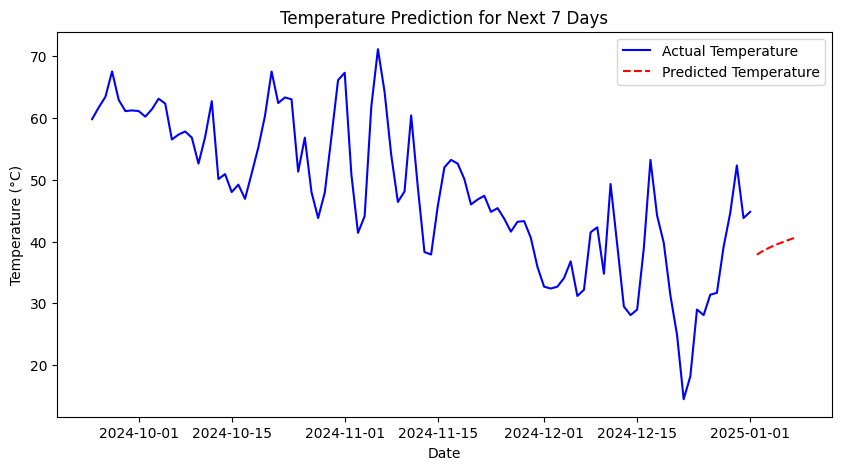

In [24]:
# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(df.index[-100:], scaler.inverse_transform(df["temp"].values[-100:].reshape(-1, 1)), label="Actual Temperature", color='blue')
plt.plot(future_dates, future_predictions, label="Predicted Temperature", linestyle="dashed", color='red')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Temperature Prediction for Next 7 Days")
plt.show()